### MountainCar-v0 with DQL
Based on [this tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) from the PyTorch website.

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

game_name = "MountainCar-v0"
env = gym.make(game_name)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args: any) -> None:
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int) -> Transition:
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations: int, n_actions: int):
        super(DQN, self).__init__()
        hidden_size = 64
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Hyperparameters and utilities

- BATCH_SIZE is the number of transitions sampled from the replay buffer
- GAMMA is the discount factor as mentioned in the previous section
- EPS_START is the starting value of epsilon
- EPS_END is the final value of epsilon
- EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
- TAU is the update rate of the target network
- LR is the learning rate of the ``AdamW`` optimizer
- MEMORY_SIZE is the maximum size of the replay buffer

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
MEMORY_SIZE = 10000

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

In [5]:
steps_done = 0
episode_durations = []

def select_action(state: torch.Tensor) -> torch.Tensor:
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # Pick action with the largest expected reward
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Pick a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_duration(show_result: bool = False) -> None:
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

#### Training loop

In [6]:
def optimize_model() -> None:
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) # [(state, action, next_state, reward), ...] -> [(state, ...), (action, ...), (next_state, ...), (reward, ...)]

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state is the one after which the episode ends)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
    # These are the actions which would've been taken for each batch state according to policy_net.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based on the "older" target_net; selecting their best reward with max(1).values.
    # This is merged based on the mask, such that we'll have either the expected state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss_fn = nn.SmoothL1Loss()
    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete
Best episode: 280, duration: 88


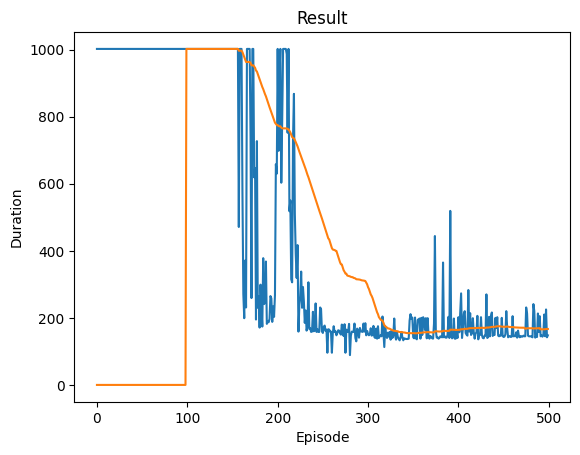

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
if torch.cuda.is_available():
    num_episodes = 10000
else:
    num_episodes = 500
use_rewards = True

record_episode = -1
record_policy = None
record_duration = 1e9

for i_episode in range(num_episodes):
    state, info = env.reset(seed=i_episode)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or t>1000

        if terminated:
            next_state = None
            if t < record_duration:
                record_episode = i_episode
                record_duration = t
                record_policy = policy_net.state_dict()
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_duration()
            break

print('Complete')
print(f'Best episode: {record_episode}, duration: {record_duration}')
plot_duration(show_result=True)
plt.ioff()
plt.show()

In [8]:
gui = True
env_gui = gym.make(game_name, render_mode='human' if gui else None)

def play_game(seed: int = None) -> None:
    state, _ = env_gui.reset(seed=seed)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, _, terminated, truncated, _ = env_gui.step(action.item())
        if terminated or truncated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    print(f'Terminated: {terminated}, Truncated: {truncated}, Steps: {t}')
    if gui:
        input('Press Enter to continue...')

play_game()

if record_policy is not None:
    print(f'Replaying the best episode ({record_episode}):', end=' ')
    backup_policy = policy_net.state_dict()
    policy_net.load_state_dict(record_policy)
    play_game(seed=record_episode)
    policy_net.load_state_dict(backup_policy)
    
env.close()
env_gui.close()

Terminated: True, Truncated: False, Steps: 150
Replaying the best episode (280): Terminated: True, Truncated: False, Steps: 144
